In [1]:
### imports
import numpy as np
import pandas as pd
import ast
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.base import clone

import sys

sys.path.append("..")
sys.path.append("../src")

from src.datahandling.loading import load_data  # loading
import src.datahandling.visualization as vis  # plotting
from src.models.ma import MovingAverage  # model
from src.datahandling.preprocessing import (
    DataCleaner,
    SupervisedTransformer,
    train_test_split,
)  # preprocessing

### load benchmarks
benchmarks = pd.read_csv("../results/benchmarks.csv")

# Model: Moving Average

The _Moving Average_ model, the most basic model within this project, operates on the principle that the value of the next time step is computed as the average of the preceding $n$ values. In future we also refer to $n$ as _"window size"_. Furthermore, the model is expanded by incorporating a discount factor $\gamma \in (0,1]$, which assigns varying weights to these values. Consequently, it closely resembles the concept of discounting employed in determining future rewards within reinforcement learning. The formula for the _Moving Average_ model is expressed as follows:

$$\hat{y}_ {t+1} = \tfrac{1}{n} \sum_ {i=0}^{n-1} \gamma^i \cdot y_ {t-i}$$

Note that by setting $n = 1$ the model reduces to a very naive model that simply predicts the value of the current time step. This can be seen as the most simplistic approach to the problem and will be therefore be referred to as baseline model.
Both, $n$ and $\gamma$ are hyperparamaters that will be tuned for each dataset individually in the following sections.

The model is implemented in the file `src/models/ma.py`. 


In [2]:
### Define the model
model = Pipeline(
    [
        ("st", SupervisedTransformer()),
        ("ma", MovingAverage()),
    ]
)

In [3]:
### Define the hyperparameter grid
param_grid = {
    "st__horizon": ["10min", "hourly", "daily"],  # different tasks
    "st__window_size": [1, 5, 10, 100, 200],
    "ma__discount": np.round(np.linspace(0.5, 1, 6), 2),
}

## British Dataset - Kelmarsh

For a description and analysis of the dataset, please refer to the notebook `DataInspection.ipynb`. 

The dataset is loaded and cleaned in the following cell. As the _Moving Average_ model only relies on past values of the target variable and not on any other features, we only need to load the target variable _Power (kW)_. The SupervisedTransformer is then used to transform the most recent #window size values into a dataframe.

In [4]:
### loading data
TURBINE_ID = 2
data_british = load_data(turbine_id=TURBINE_ID, which_data="British")

### cleaning data
cleaner = DataCleaner(features=["Power (kW)"], rename_features=["power"])
data_british = cleaner.transform(data_british)

In [8]:
### hyperparameter tuning
### RUNTIME: ~6 min on my machine
do_gridsearch = False

X = data_british
y = data_british["power"]


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=5),
    verbose=1,
    refit=False,
)

if do_gridsearch:
    grid_search.fit(X, y)
    res_gs_brit = pd.DataFrame(grid_search.cv_results_)
    ### store results in csv-file
    pd.DataFrame(res_gs_brit).to_csv("../results/results_gs_ma_brit.csv")
else:
    res_gs_brit = pd.read_csv("../results/results_gs_ma_brit.csv")

Let's have a look at the results of the performed gridsearch.

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


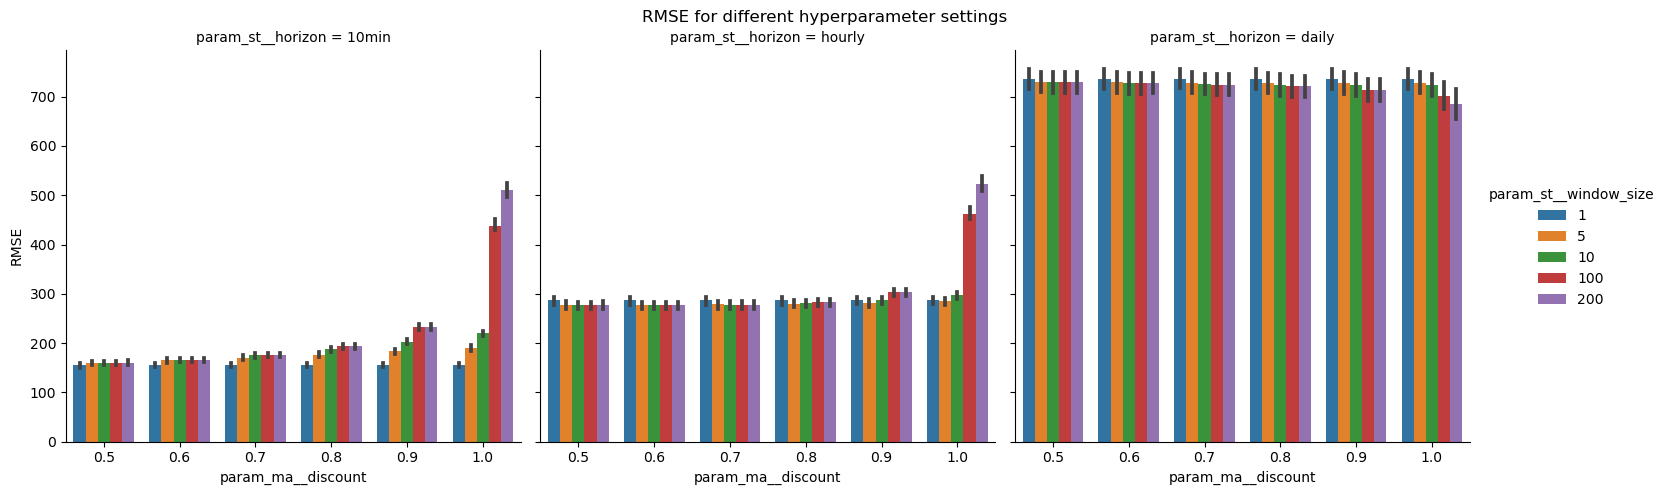

In [6]:
vis.plot_gridsearch_results(
    res_gs_brit, x="param_ma__discount", hue="param_st__window_size"
)

__Analysis:__

In [10]:
### extract best parameters of each model for each horizon
best_params_brit = (
    res_gs_brit.set_index(["params"])
    .groupby("param_st__horizon")
    .idxmax()["mean_test_score"]
)

for horizon in best_params_brit.index:
    print(f"Best parameters for horizon '{horizon}': {best_params_brit[horizon]}")

Best parameters for horizon '10min': {'ma__discount': 0.5, 'st__horizon': '10min', 'st__window_size': 1}
Best parameters for horizon 'daily': {'ma__discount': 1.0, 'st__horizon': 'daily', 'st__window_size': 200}
Best parameters for horizon 'hourly': {'ma__discount': 0.6, 'st__horizon': 'hourly', 'st__window_size': 100}


In [11]:
### create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][0]
test_end = benchmarks["test_end"][0]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_british, test_start=test_start, test_end=test_end, target_var="power"
)

### create models and refit them with best parameters,
#   then predict on test set
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_brit[horizon])
    )
    models[horizon].fit(X_train, y_train)
    predictions[horizon] = models[horizon].predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)

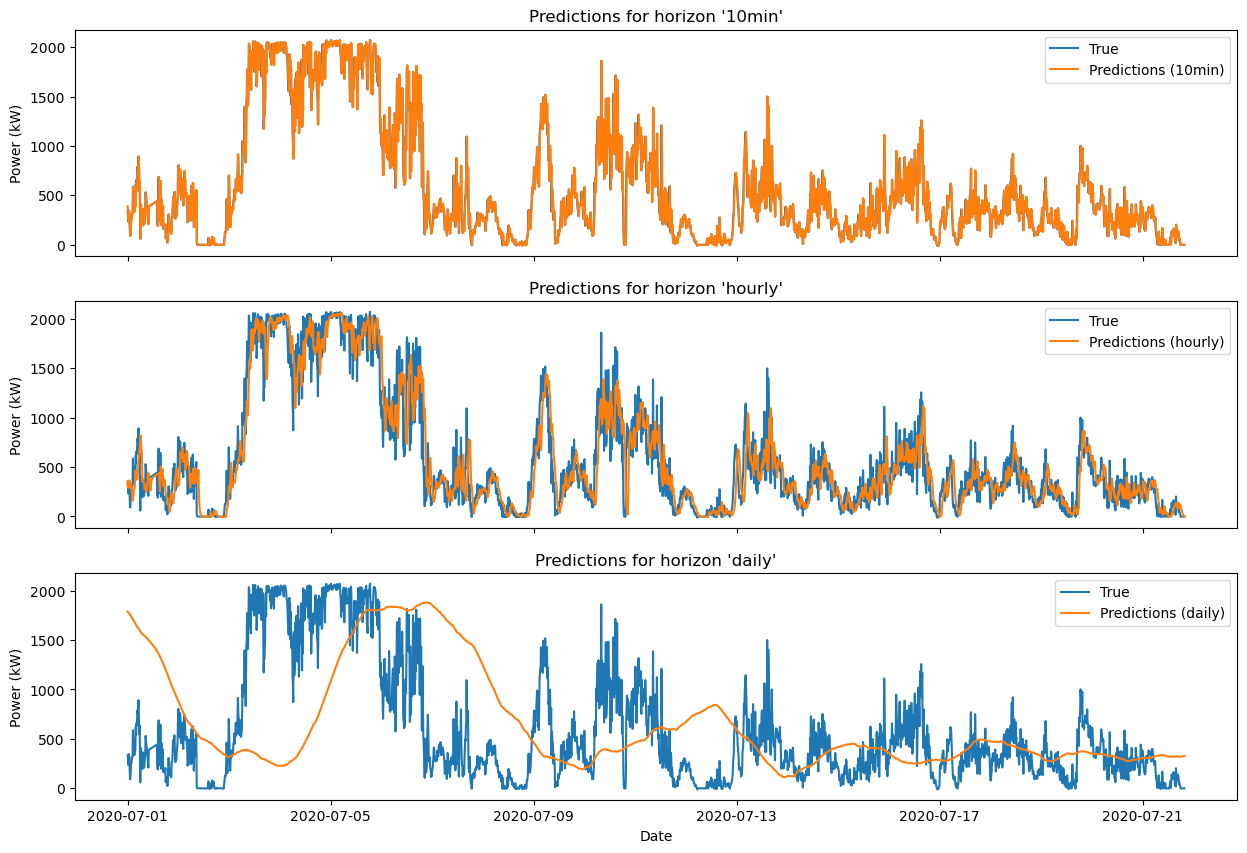

In [12]:
### plot first 3000 predictions
vis.plot_predictions(predictions.iloc[:3000], y_test.iloc[:3000])

__Analysis:__ 

- Forecasting horizon of 10 minutes:
- Forecasting horizon of one hour:
- Forecasting horizon of one day:
    -  Captures trends but fails to predict peaks and troughs. Also fails to predict sudden changes in the data.

## Brazilian Dataset - Beberine

We follow the exact same procedure as for the British dataset.

In [13]:
### loading data
TURBINE_ID = 1  # Turbine 1 has a benchmark loss
data_braz = load_data(turbine_id=TURBINE_ID, which_data="Brazilian")

### cleaning data
cleaner = DataCleaner(features=["active_power_total"], rename_features=["power"])
data_braz = cleaner.transform(data_braz)

In [17]:
### hyperparameter tuning
### RUNTIME: ~ 2 min on my machine
do_gridsearch = False

X = data_braz
y = data_braz["power"]


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=5),
    verbose=1,
    refit=False,
)
if do_gridsearch:
    grid_search.fit(X, y)
    res_gs_braz = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_braz).to_csv("../results/results_gs_ma_braz.csv")
else:
    # load results
    res_gs_braz = pd.read_csv("../results/results_gs_ma_braz.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


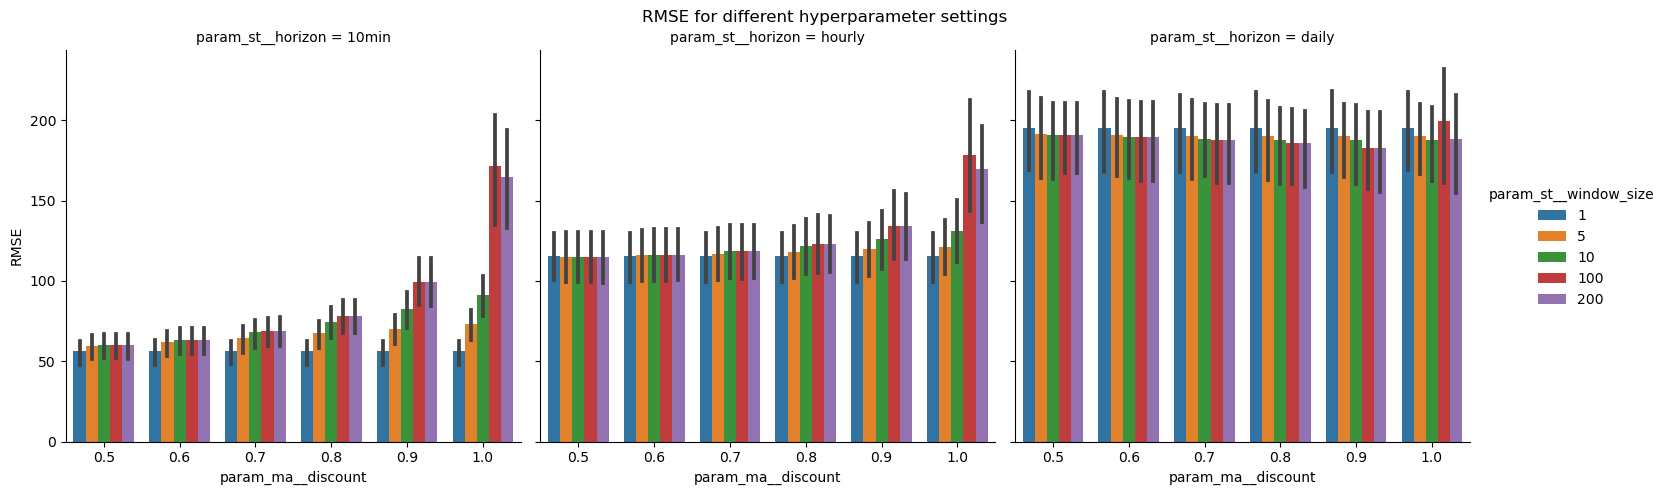

In [18]:
vis.plot_gridsearch_results(
    res_gs_braz, x="param_ma__discount", hue="param_st__window_size"
)

In [19]:
### extract best parameters of each model for each horizon
best_params_braz = (
    res_gs_braz.set_index(["params"])
    .groupby("param_st__horizon")
    .idxmax()["mean_test_score"]
)

for horizon in best_params_braz.index:
    print(f"Best parameters for horizon '{horizon}': {best_params_braz[horizon]}")

Best parameters for horizon '10min': {'ma__discount': 0.5, 'st__horizon': '10min', 'st__window_size': 1}
Best parameters for horizon 'daily': {'ma__discount': 0.9, 'st__horizon': 'daily', 'st__window_size': 200}
Best parameters for horizon 'hourly': {'ma__discount': 0.5, 'st__horizon': 'hourly', 'st__window_size': 5}


In [ ]:
### create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][3]
test_end = benchmarks["test_end"][3]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_braz, test_start=test_start, test_end=test_end, target_var="power"
)

### create models and refit them with best parameters,
#   then predict on test set
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_brit[horizon])
    )
    models[horizon].fit(X_train, y_train)
    predictions[horizon] = models[horizon].predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)

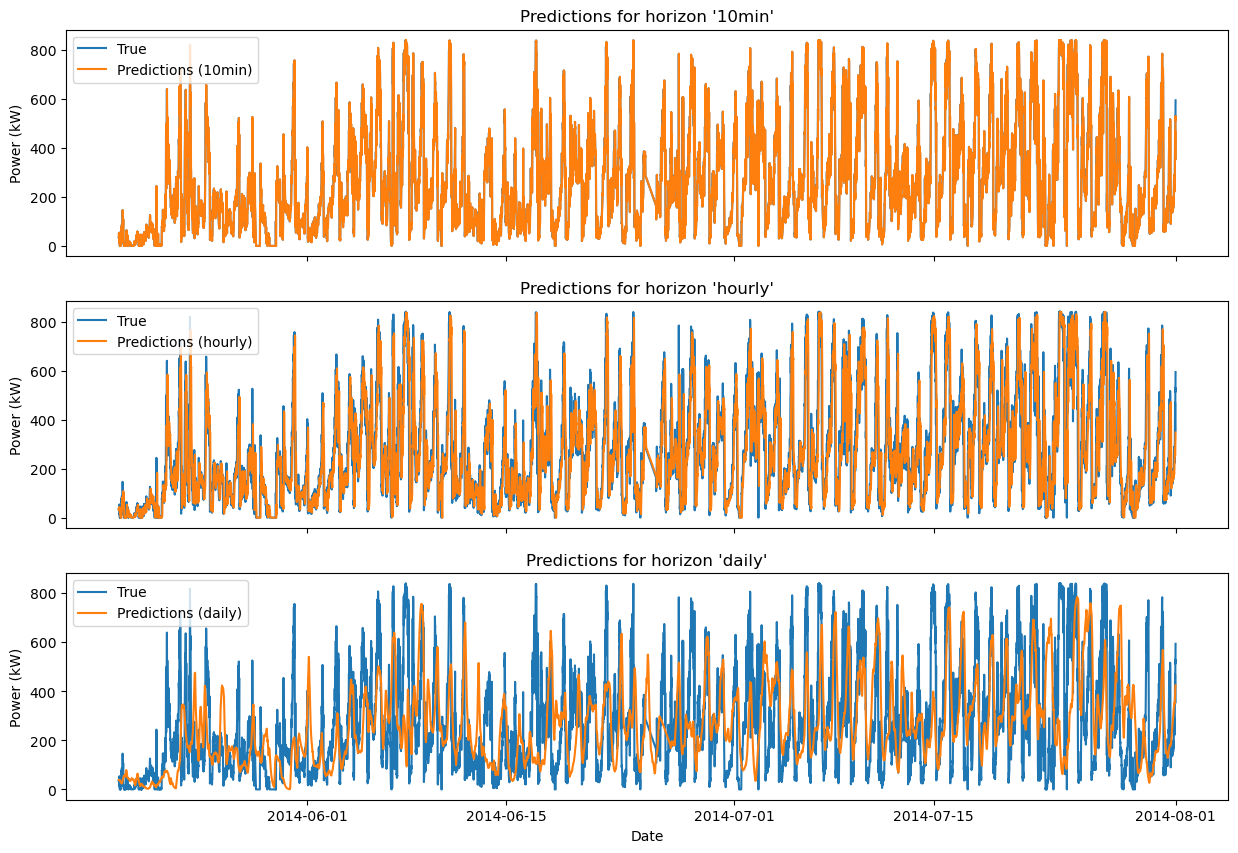

In [ ]:
### plot predictions
vis.plot_predictions(predictions, y_test)

## Transfer Learning Approach

Since there is not really the need for fitting the model, i.e. no parameters have to be learned, this model can be seen as already fulfilling the transfer learning challenge because of its simplicity. 

## Summary